In [1]:
from pathlib import Path
import xarray as xr
import math
import matplotlib.pyplot as plt
import geopandas as gpd
import xesmf as xe
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [2]:
# papermill parameters cell

var = 'prsn'
cmip6_directory = '/beegfs/CMIP6/arctic-cmip6/CMIP6'
repo_directory = '/center1/CMIP6/jdpaul3/regrid_global/cmip6-utils'


In [3]:
# Parameters
cmip6_directory = "/beegfs/CMIP6/arctic-cmip6/CMIP6"
repo_directory = "/home/jdpaul3/cmip6-utils"
var = "clt"


In [4]:
# create Path objects
cmip6_directory = Path(cmip6_directory)
repo_directory = Path(repo_directory)

# get coastlines for plotting
coastlines = gpd.read_file(repo_directory.joinpath("indicators", "shp", "ne_110m_coastline.shp"))
# get target grid for regridding
# this is a known global extent variable 'tas' and the regridding in this notebook does not use masking
dst_ds = xr.open_dataset(cmip6_directory.joinpath("ScenarioMIP/NCAR/CESM2/ssp370/r11i1p1f1/Amon/tas/gn/v20200528/tas_Amon_CESM2_ssp370_r11i1p1f1_gn_206501-210012.nc"))

In [5]:
def init_regridder(src_ds, dst_ds):
    # cache existing encoding / attrs
    lon_enc = dst_ds["lon"].encoding
    lon_attrs = dst_ds["lon"].attrs
    # convert to -180 to 180 lon coords, and reapply encoding / attrs
    dst_ds["lon"] = (dst_ds["lon"] + 180) % 360 - 180
    dst_ds["lon"].encoding = lon_enc
    dst_ds["lon"].attrs = lon_attrs
    # probably doesn't matter but technically correct after adjustment
    dst_ds["lon"].attrs["valid_max"] = 180
    dst_ds["lon"].attrs["valid_min"] = -180
    # sort
    dst_ds = dst_ds.sortby(dst_ds.lon, ascending=True)
    # initialize the regridder which now contains standard -180 to 180 longitude values
    # had to add ignore_degenerate flag to get some Omon freq files to regrid without error!
    regridder = xe.Regridder(src_ds, dst_ds, "bilinear", unmapped_to_nan=True, periodic=True, ignore_degenerate=True)
    return regridder


def categorize_and_plot_var_by_model_freq(var):
    # get all files for a variable
    var_fps = list(cmip6_directory.glob(f"**/{var}/**/*.nc"))

    if len(var_fps) == 0:
        print("No files found for that variable, aborting!")
        return {}
    else:
        # get all models
        models=list(set([fp.parts[-8] for fp in var_fps]))
        # create dict of freqs for each model
        model_freq_dict = {}
        for model in models:
            freqs = []
            for fp in [fp for fp in var_fps if fp.parts[-8]==model]:
                freqs.append(fp.parts[-5])
            model_freq_dict[model] = list(set(freqs))

        out_dict={}
        for model in model_freq_dict.keys():
            plot_fps = []
            for freq in model_freq_dict[model]:
                # get first filepath for model/freq combo
                plot_fps.append([fp for fp in var_fps if fp.parts[-8]==model and fp.parts[-5]==freq][0])
            sub_dict = regrid_categorize_multiplot(plot_fps, var)
            out_dict[model]=sub_dict
        return out_dict


def regrid_categorize_multiplot(plot_fps, var):
    model = plot_fps[0].parts[-8]
    sub_dict = {}

    nrows=math.ceil(len(plot_fps)/3)
    ncols=3
    fig_height= nrows*4
    
    lat_slice = slice(50,90)
    lon_slice = slice(-170, -120)

    fig, _axes = plt.subplots(nrows, ncols, figsize=(12,fig_height))
    for ax_tuple, fp in zip(enumerate(fig.axes), plot_fps):

        freq = fp.parts[-5]
        
        src_ds = xr.open_dataset(fp)

        # count the non-nan values
        non_nans = (~np.isnan(src_ds[var].sel(time=src_ds['time'][0]))).sum()
        nans = (np.isnan(src_ds[var].sel(time=src_ds['time'][0]))).sum()
        total_values = nans + non_nans
        # use 50% as threshold to determine land/sea only categories
        # if nans are less than 10% call it global category
        if nans/total_values < .1:
            category = "global"
        elif nans/total_values > .5:
            category = "land"
        else:
            category = "sea"

        r = init_regridder(src_ds, dst_ds)
        regrid_ds = r(src_ds)

        ax = ax_tuple[1]
        regrid_ds[var].sel(time=regrid_ds['time'][0], lat=lat_slice, lon=lon_slice).plot(cmap='plasma', ax=ax, vmin=0, add_colorbar=False)
        coastlines.plot(color='red', ax=ax)
        ax.set_title(f"{freq}: {category}")
        ax.set_xlabel("")
        ax.set_ylabel("")

        sub_dict[freq]=category
        
    fig.suptitle(f"{model}")
    fig.tight_layout()
    plt.show()

    return sub_dict


def categorize_var_by_model_freq(var):
    # get all files for a variable
    var_fps = list(cmip6_directory.glob(f"**/{var}/**/*.nc"))

    if len(var_fps) == 0:
        print("No files found for that variable, aborting!")
        return {}
    else:
        # get all models
        models=list(set([fp.parts[-8] for fp in var_fps]))
        # create dict of freqs for each model
        model_freq_dict = {}
        for model in models:
            freqs = []
            for fp in [fp for fp in var_fps if fp.parts[-8]==model]:
                freqs.append(fp.parts[-5])
            model_freq_dict[model] = list(set(freqs))
            
        print(f"Summary of models and frequencies for variable {var}:")
        df = pd.concat(pd.DataFrame({'model':k, 'freq':v}) for k, v in model_freq_dict.items())
        print(pd.crosstab(df.model, df.freq))

        out_dict={}
        for model in model_freq_dict.keys():
            plot_fps = []
            for freq in model_freq_dict[model]:
                # get first filepath for model/freq combo
                plot_fps.append([fp for fp in var_fps if fp.parts[-8]==model and fp.parts[-5]==freq][0])

            model = plot_fps[0].parts[-8]
            sub_dict = {}

            for fp in plot_fps:
                freq = fp.parts[-5]
                src_ds = xr.open_dataset(fp)
                # count the non-nan values
                non_nans = (~np.isnan(src_ds[var].sel(time=src_ds['time'][0]))).sum()
                nans = (np.isnan(src_ds[var].sel(time=src_ds['time'][0]))).sum()
                total_values = nans + non_nans
                # use 50% as threshold to determine land/sea only categories
                # if nans are less than 10% call it global category
                if nans/total_values < .1:
                    category = "global"
                elif nans/total_values > .5:
                    category = "land"
                else:
                    category = "sea"

                sub_dict[freq]=category
                
            out_dict[model]=sub_dict
            
        return out_dict

def summarize_results_categories(results_dict):
    category_dict = {}
    for result in results_dict.keys():
        categories = []
        for freq in results_dict[result].keys():
            categories.append(results_dict[result][freq])
        if len(list(set(categories))) > 1:
            category_dict[result] = "mixed"
        else:
            category_dict[result] = list(set(categories))[0]
    return category_dict

In [6]:
results = categorize_var_by_model_freq(var)

Summary of models and frequencies for variable clt:
freq             Amon  Eday  day
model                           
CESM2               1     0    1
CESM2-WACCM         1     0    1
CNRM-CM6-1-HR       1     0    1
EC-Earth3-Veg       1     0    1
GFDL-ESM4           1     0    0
HadGEM3-GC31-LL     1     0    1
HadGEM3-GC31-MM     1     0    1
KACE-1-0-G          1     0    1
MIROC6              1     0    1
MPI-ESM1-2-HR       1     0    1
MPI-ESM1-2-LR       1     0    1
NorESM2-MM          1     1    1
TaiESM1             1     1    1


In [7]:
summary = summarize_results_categories(results)
summary

{'TaiESM1': 'global',
 'KACE-1-0-G': 'global',
 'MIROC6': 'global',
 'EC-Earth3-Veg': 'global',
 'NorESM2-MM': 'global',
 'HadGEM3-GC31-LL': 'global',
 'MPI-ESM1-2-LR': 'global',
 'CNRM-CM6-1-HR': 'global',
 'CESM2-WACCM': 'global',
 'CESM2': 'global',
 'GFDL-ESM4': 'global',
 'MPI-ESM1-2-HR': 'global',
 'HadGEM3-GC31-MM': 'global'}

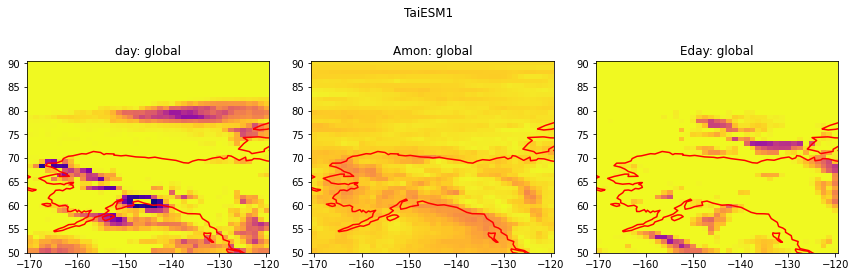

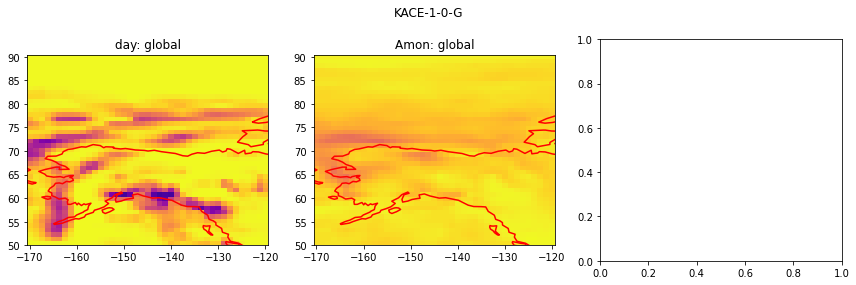

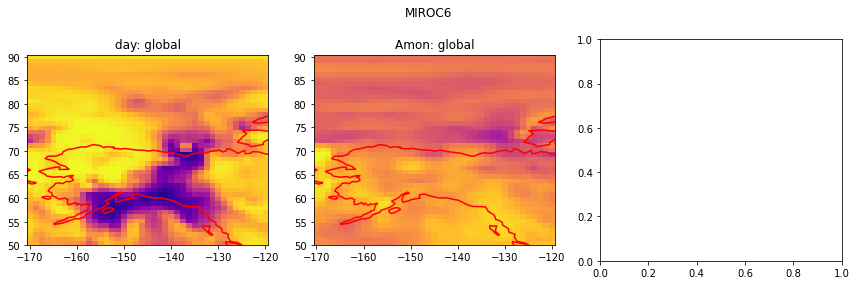

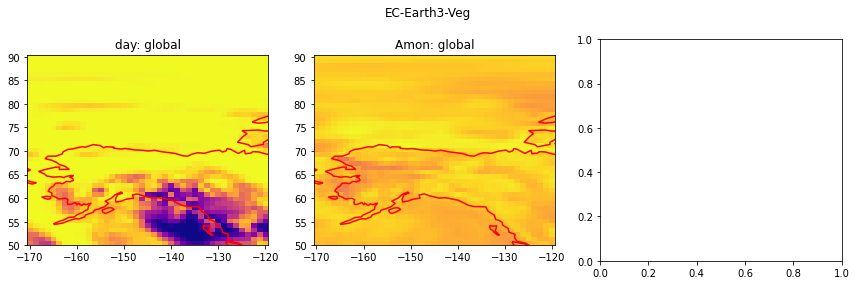

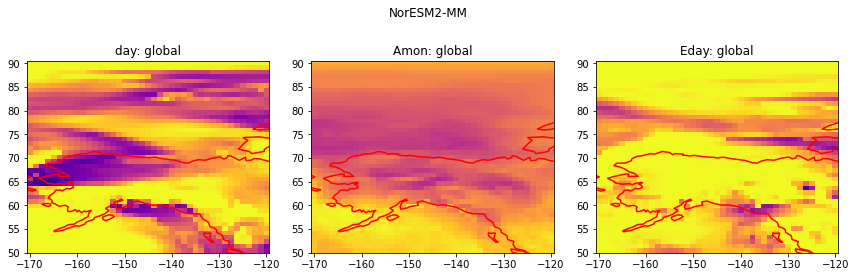

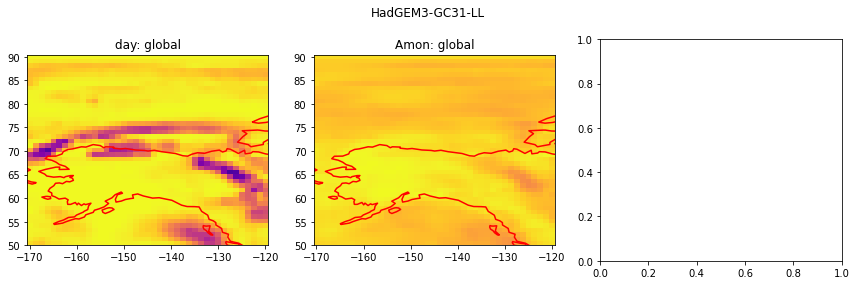

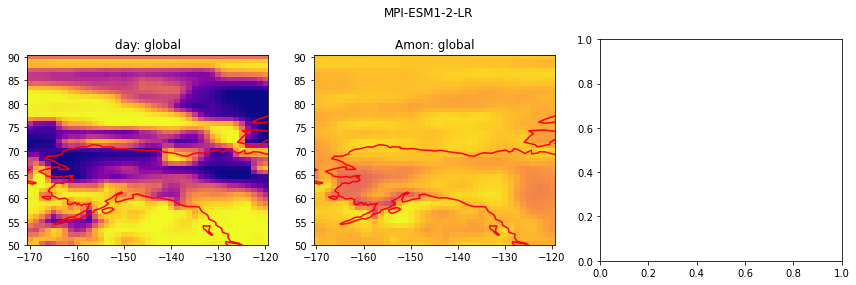

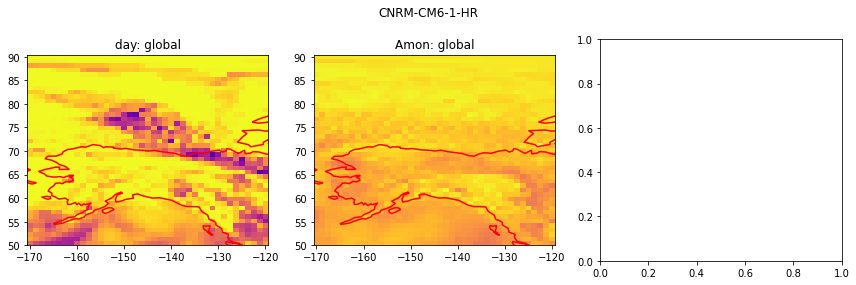

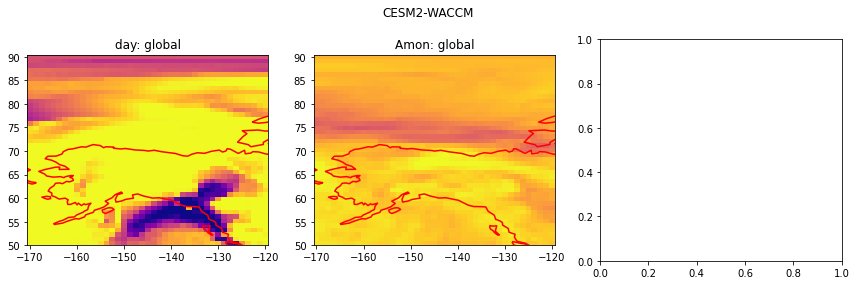

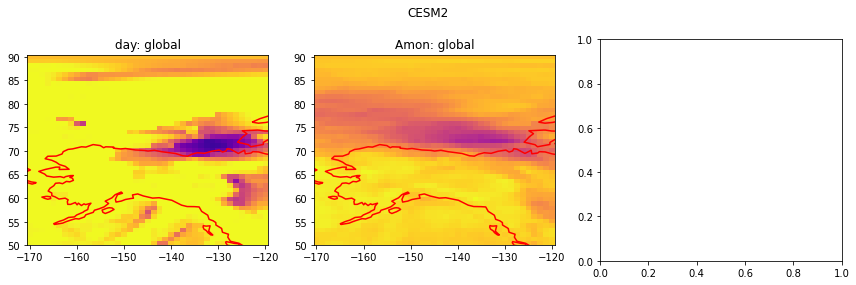

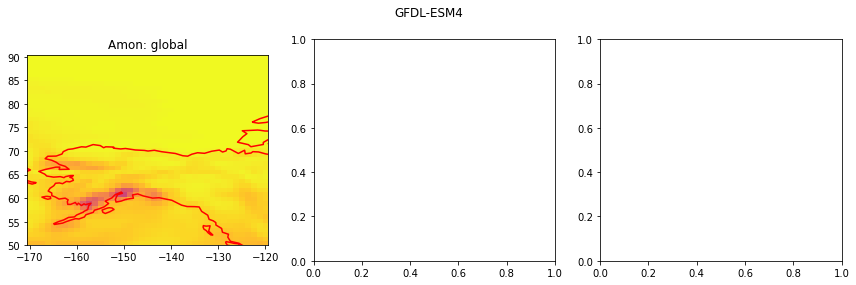

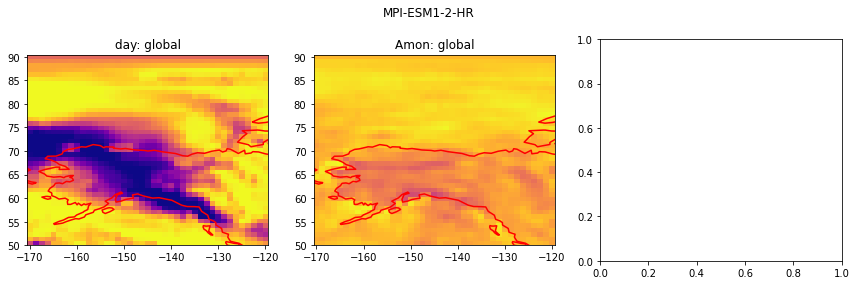

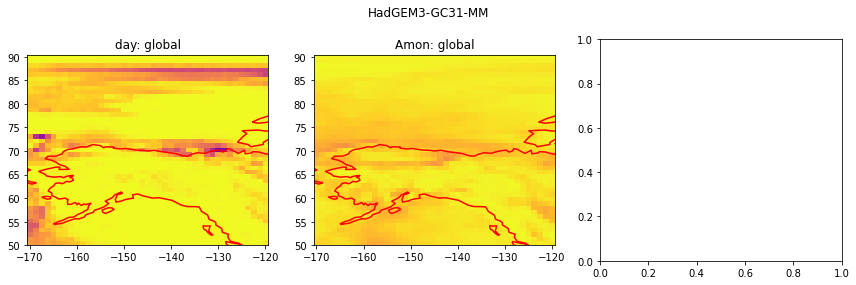

{'TaiESM1': {'day': 'global', 'Amon': 'global', 'Eday': 'global'},
 'KACE-1-0-G': {'day': 'global', 'Amon': 'global'},
 'MIROC6': {'day': 'global', 'Amon': 'global'},
 'EC-Earth3-Veg': {'day': 'global', 'Amon': 'global'},
 'NorESM2-MM': {'day': 'global', 'Amon': 'global', 'Eday': 'global'},
 'HadGEM3-GC31-LL': {'day': 'global', 'Amon': 'global'},
 'MPI-ESM1-2-LR': {'day': 'global', 'Amon': 'global'},
 'CNRM-CM6-1-HR': {'day': 'global', 'Amon': 'global'},
 'CESM2-WACCM': {'day': 'global', 'Amon': 'global'},
 'CESM2': {'day': 'global', 'Amon': 'global'},
 'GFDL-ESM4': {'Amon': 'global'},
 'MPI-ESM1-2-HR': {'day': 'global', 'Amon': 'global'},
 'HadGEM3-GC31-MM': {'day': 'global', 'Amon': 'global'}}

In [8]:
categorize_and_plot_var_by_model_freq(var)